### Web APIs & Classification by Elton Yeo

#### Problem Statement

Of two subreddits (talesfromyourserver and talesfromthefrontdesk), to determine which subreddit a given post came from. We require such natural lanaguage processing (NLP) abilities because we (a group of data scientists) have been commissioned by the Ministry of Manpower (MOM) to solicit feedback from workers in the service industry, to better understand the current state and concerns of these workers. 

Within  such feedback, we want to further classify them into feedback from service workers in the F&B industry, and feedback from service workers at the frontdesk in the hospitality industry. This will allow us to then perform more in-depth studies into the specific feedback, and generate insights for the specific sub-industries for MOM.

We will consider two different classication models for our predictions, Naive Bayes and Logistic Regression, and also use CountVectorizer and TfidfVectorizer in turn to treat the data. We will evaluate the models using the accuracy score, and Receiver Operating Characteristic (ROC) curve score, which we will elaborate upon in detail later. 


### Contents:
- [Exploratory Data Analysis and Cleaning](#Exploratory-Data-Analysis-and-Cleaning)
- [Preprocessing](#Preprocessing)
- [Data Visualisation](#Data-Visualisation)
- [Modelling](#Modelling)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

In [1]:
# libraries are imported here

import requests
import time 
import pandas as pd
import numpy as np
import random
import nltk
import regex as re
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Exploratory Data Analysis and Cleaning

#### Understanding preliminary scraped data from reddit

This section will help us to understand what the scraped data looks like, and what we need to focus on in cleaning and processing the data later. 

In [2]:
url = 'https://www.reddit.com/r/TalesFromRetail.json'
headers = {'User-agent': 'hello'}
res = requests.get(url, headers=headers)

In [3]:
data_json = res.json()

#looking at keys. there are two main ones, 'kind' and 'data'
sorted(data_json.keys())

['data', 'kind']

In [4]:
#there is nothing needed in 'kind'; we can ignore it
data_json['kind']

'Listing'

In [5]:
#everything we want is in 'data'
data_json['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [6]:
#specifically, contained in 'children' are the posts which we want
data_json['data']['children'][0]['data']

{'approved_at_utc': None,
 'subreddit': 'TalesFromRetail',
 'selftext': 'Welcome to /r/TalesFromRetail\'s Express Lane - your quick stop for news about the current pandemic and how things are going with your store, your customers and yourselves.  \n\nPlease remember all rules regarding anonymity and derogatory speech.  \n\n*(All comments will be sorted by "new")*',
 'author_fullname': 't2_6l4z3',
 'saved': False,
 'mod_reason_title': None,
 'gilded': 0,
 'clicked': False,
 'title': 'Weekly TFR Express Lane Checkout - Post your stories and experiences with the Coronavirus here - stay safe everyone!',
 'link_flair_richtext': [],
 'subreddit_name_prefixed': 'r/TalesFromRetail',
 'hidden': False,
 'pwls': 6,
 'link_flair_css_class': None,
 'downs': 0,
 'hide_score': False,
 'name': 't3_g0kqey',
 'quarantine': False,
 'link_flair_text_color': 'dark',
 'author_flair_background_color': '',
 'subreddit_type': 'public',
 'ups': 13,
 'total_awards_received': 0,
 'media_embed': {},
 'author_flair

In [7]:
#scraping more posts by using "after" key which refers to last post
#this will be anchor for next time I hit reddit's API
data_json['data']['after']

't3_fytxvy'

We now have sufficient information to create for-loops to scrape the posts from the subreddits, talesfromthefrontdesk and talesfromyourserver.

#### Scraping data from subreddit - talesfromthefrontdesk

In [8]:
#scraping posts from subreddit

posts_frontdesk = []
after = None
url = 'https://www.reddit.com/r/TalesFromTheFrontDesk.json'

for a in range(40):
    if after == None:
        current_url = url
    else:
        current_url = url + '?after=' + after
    print(current_url)
    res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']]
    posts_frontdesk.extend(current_posts)
    after = current_dict['data']['after']
    
    pd.DataFrame(posts_frontdesk).to_csv('frontdesk.csv', index = False)

    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(2,6)
    print(sleep_duration)
    time.sleep(sleep_duration)

https://www.reddit.com/r/TalesFromTheFrontDesk.json
5
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_g2yten
6
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_g03zct
5
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fvua8t
3
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fs7dmi
3
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fq95zo
3
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fngjyk
3
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fm6vqm
2
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fk3zxu
5
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fjcz1x
3
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fiboy9
5
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fhx1ak
3
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_fgwlsv
4
https://www.reddit.com/r/TalesFromTheFrontDesk.json?after=t3_ffgw0z
2
https://www.reddit.com/r/TalesFromTh

In [9]:
#checking total number of posts
len(posts_frontdesk)

984

In [10]:
#looking at the various columns
posts_frontdesk = pd.DataFrame(posts_frontdesk)
posts_frontdesk.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,crosspost_parent_list,crosspost_parent,author_cakeday
0,None,TalesFromTheFrontDesk,Hey all! Gotta give my props to /u/User0x for ...,t2_968wc,False,None,0,False,"Coronavirus Megathread, this is totally the fi...","[{'e': 'text', 't': 'Short'}]",...,290994,1.582381e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
1,None,TalesFromTheFrontDesk,Want to talk about something that isn't a fron...,t2_6l4z3,False,None,0,False,Free For All Thread,[],...,290994,1.587161e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
2,None,TalesFromTheFrontDesk,"Hey all, I know I said I wouldn't post since I...",t2_2hu3fbu1,False,None,0,False,My expensive finger.,"[{'e': 'text', 't': 'Medium'}]",...,290994,1.587329e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
3,None,TalesFromTheFrontDesk,My first call of the evening is a driver for a...,t2_16zqg1,False,None,0,False,Even in the middle of a pandemic it's still a ...,"[{'e': 'text', 't': 'Long'}]",...,290994,1.587291e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
4,None,TalesFromTheFrontDesk,Background: I worked at a Full service semi-lu...,t2_fc3x351,False,None,0,False,Today's Tale...,"[{'e': 'text', 't': 'Long'}]",...,290994,1.587340e+09,0,None,False,NaN,NaN,NaN,NaN,NaN


Having studied the various columns, I have decided that the 'selftext' and 'title' columns are the most pertinent for our model. 'Selftext' contains the body of the subreddit post while 'title' is self-explanatory. 

I will combine these two columns into one 'final_post' column, and remove any duplicates.

In [11]:
#combining 'selftext' and 'title' into 'final_post'
posts_frontdesk['final_post']=posts_frontdesk['selftext']+posts_frontdesk['title']

#confirming that there is one additional column
posts_frontdesk.shape

(984, 108)

In [12]:
#making sure all posts are unique based on "final_post" column
posts_frontdesk[posts_frontdesk.duplicated(['final_post'])]

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,created_utc,num_crossposts,media,is_video,post_hint,preview,crosspost_parent_list,crosspost_parent,author_cakeday,final_post
65,None,TalesFromTheFrontDesk,Want to talk about something that isn't a fron...,t2_6l4z3,False,None,0,False,Free For All Thread,[],...,1.586557e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,Want to talk about something that isn't a fron...
91,None,TalesFromTheFrontDesk,Want to talk about something that isn't a fron...,t2_6l4z3,False,None,0,False,Free For All Thread,[],...,1.585952e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,Want to talk about something that isn't a fron...
131,None,TalesFromTheFrontDesk,Want to talk about something that isn't a fron...,t2_6l4z3,False,None,0,False,Free For All Thread,[],...,1.585347e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,Want to talk about something that isn't a fron...
182,None,TalesFromTheFrontDesk,Want to talk about something that isn't a fron...,t2_6l4z3,False,None,0,False,Free For All Thread,[],...,1.584742e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,Want to talk about something that isn't a fron...
274,None,TalesFromTheFrontDesk,Want to talk about something that isn't a fron...,t2_6l4z3,False,None,0,False,Free For All Thread,[],...,1.584137e+09,0,None,False,self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN,Want to talk about something that isn't a fron...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,None,TalesFromTheFrontDesk,Twas be the night before my 7-3 shift and I co...,t2_5d0gou2k,False,None,0,False,0-100 very quickly,"[{'e': 'text', 't': 'Long'}]",...,1.585405e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,Twas be the night before my 7-3 shift and I co...
980,None,TalesFromTheFrontDesk,"We don’t have rollaway beds, can't be the only...",t2_5vlm3nhx,False,None,0,False,Who should have gotten the suite?,"[{'e': 'text', 't': 'Medium'}]",...,1.585420e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"We don’t have rollaway beds, can't be the only..."
981,None,TalesFromTheFrontDesk,"It all started with the Gay Prostitute, who wa...",t2_cuep5,False,None,0,False,Very interesting friday night....,"[{'e': 'text', 't': 'Long'}]",...,1.585388e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"It all started with the Gay Prostitute, who wa..."
982,None,TalesFromTheFrontDesk,"So, first time poster (I have a ton of stories...",t2_4acufumu,False,None,0,False,"Sir, that’s ours.","[{'e': 'text', 't': 'Medium'}]",...,1.585321e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"So, first time poster (I have a ton of stories..."


In [13]:
#dropping all duplicate rows based on "final_post" column, but keeping one copy of the row 

posts_frontdesk.drop_duplicates(subset='final_post', keep='first', inplace=True)

#confirming new number of rows
posts_frontdesk.shape

(846, 108)

There was a moderator post pinned at the start of the subreddit. We will proceed to remove it because its content is adminstrative. 

In [14]:
#removing pinned post by moderator and resetting index for easy reference later
posts_frontdesk = posts_frontdesk.drop(0, axis=0).reset_index(drop=True)

#confirming new number of rows
posts_frontdesk.shape

(845, 108)

I will now keep only the 'final_post' and 'subreddit' columns, and save the data in a csv file. 

In [15]:
#keeping only the 'final_post' and 'subreddit' columns which we are interested in
posts_frontdesk = posts_frontdesk[['final_post', 'subreddit']]

#checking our final version of 'posts_frontdesk'
posts_frontdesk.head()

,final_post,subreddit
0,Want to talk about something that isn't a fron...,TalesFromTheFrontDesk
1,"Hey all, I know I said I wouldn't post since I...",TalesFromTheFrontDesk
2,My first call of the evening is a driver for a...,TalesFromTheFrontDesk
3,Background: I worked at a Full service semi-lu...,TalesFromTheFrontDesk
4,Tiny bit of background- I work at a 105 room f...,TalesFromTheFrontDesk


In [16]:
#saving our data to a csv file
pd.DataFrame(posts_frontdesk).to_csv('frontdesk.csv', index = False)

#### Scraping data from subreddit - talesfromyourserver

In [17]:
#scraping posts from subreddit

posts_service = []
after = None
url = 'https://www.reddit.com/r/TalesFromYourServer.json'

for a in range(40):
    if after == None:
        current_url = url
    else:
        current_url = url + '?after=' + after
    print(current_url)
    res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']]
    posts_service.extend(current_posts)
    after = current_dict['data']['after']
    
    pd.DataFrame(posts_service).to_csv('service.csv', index = False)

    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(2,6)
    print(sleep_duration)
    time.sleep(sleep_duration)

https://www.reddit.com/r/TalesFromYourServer.json
4
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_g3zg2c
5
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_g0ggpo
5
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fyith8
4
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fv5849
3
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_ft5rt0
4
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fs4uom
2
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fossd2
4
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fnj322
2
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fml7e4
6
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fm9nyc
2
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fljxii
4
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fktj3z
5
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fjm6w2
6
https://www.reddit.com/r/TalesFromYourServer.json?after=t3_fjn50

In [18]:
#checking total number of posts
len(posts_service)

980

In [19]:
#looking at the various columns
posts_service = pd.DataFrame(posts_service)
posts_service

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday,post_hint,preview,crosspost_parent_list,crosspost_parent
0,None,TalesFromYourServer,"Hey all, we here on the mod team wanted to do ...",t2_64eorbn,False,None,0,False,COVID-19 Official Resource and Info Megathread,[],...,338748,1.584115e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
1,None,TalesFromYourServer,"Hey all, we just want to touch base with all o...",t2_8er8z,False,None,0,False,Posting guidelines with regard to COVID-19,[],...,338748,1.585147e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
2,None,TalesFromYourServer,This happened at my first hostessing job years...,t2_1qr2gtcd,False,None,0,False,“WHY DID YOU SEAT THOSE PEOPLE?! WE WERE HERE ...,[],...,338748,1.587293e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
3,None,TalesFromYourServer,Luckily this was back in my college days and I...,t2_5o5he26a,False,None,0,False,5 year old thinks he’s my boss. Unfortunately ...,[],...,338748,1.587330e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
4,None,TalesFromYourServer,"Okay, this is one of my oldest stories about t...",t2_5a64pbsh,False,None,0,False,The Woman Who Ran With A Knife To The Bathroom,[],...,338748,1.587328e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,None,TalesFromYourServer,"Since closing our dining room, our phone has b...",t2_4pu2nh4l,False,None,0,False,75% of people who call us are fucking morons,[],...,338748,1.587152e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
976,None,TalesFromYourServer,"At work tonight, I got a phone call from a wom...",t2_2wv11xc0,False,None,0,False,Yet another Karen,[],...,338748,1.587184e+09,0,None,False,NaN,NaN,NaN,NaN,NaN
977,None,TalesFromYourServer,Hey guys I wasn't too sure where to post this ...,t2_bdg9s,False,None,0,False,Reopening on May 3rd,[],...,338748,1.587136e+09,0,None,False,True,NaN,NaN,NaN,NaN
978,None,TalesFromYourServer,I knew I said I wanted a break from work but d...,t2_390idqf6,False,None,0,False,Quarantine,[],...,338748,1.587191e+09,0,None,False,NaN,NaN,NaN,NaN,NaN


Similiar to the process for the first subreddit, we will combine the 'selftext' and 'title' columns into a 'final_post' column, and remove any duplicates.

In [20]:
#same as for the first subreddit, combining 'selftext' and 'title' columns
posts_service['final_post']=posts_service['selftext']+posts_service['title']

#confirming that there is one additional column
posts_service.shape

(980, 108)

In [21]:
#making sure all posts are unique based on "final_post" column
posts_service[posts_service.duplicated(['final_post'])]

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,created_utc,num_crossposts,media,is_video,author_cakeday,post_hint,preview,crosspost_parent_list,crosspost_parent,final_post
953,None,TalesFromYourServer,"Hey all, we here on the mod team wanted to do ...",t2_64eorbn,False,None,0,False,COVID-19 Official Resource and Info Megathread,[],...,1.584115e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"Hey all, we here on the mod team wanted to do ..."
954,None,TalesFromYourServer,"Hey all, we just want to touch base with all o...",t2_8er8z,False,None,0,False,Posting guidelines with regard to COVID-19,[],...,1.585147e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"Hey all, we just want to touch base with all o..."
955,None,TalesFromYourServer,This happened at my first hostessing job years...,t2_1qr2gtcd,False,None,0,False,“WHY DID YOU SEAT THOSE PEOPLE?! WE WERE HERE ...,[],...,1.587293e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,This happened at my first hostessing job years...
956,None,TalesFromYourServer,Luckily this was back in my college days and I...,t2_5o5he26a,False,None,0,False,5 year old thinks he’s my boss. Unfortunately ...,[],...,1.587330e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,Luckily this was back in my college days and I...
957,None,TalesFromYourServer,"Okay, this is one of my oldest stories about t...",t2_5a64pbsh,False,None,0,False,The Woman Who Ran With A Knife To The Bathroom,[],...,1.587328e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"Okay, this is one of my oldest stories about t..."
958,None,TalesFromYourServer,"Okay, so I work in a bar. A party of office wo...",t2_2vecoucs,False,None,0,False,Apparently not doing something that isn't even...,[],...,1.587239e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,"Okay, so I work in a bar. A party of office wo..."
959,None,TalesFromYourServer,So this happened some summers ago. \n\nI menti...,t2_61hvkvej,False,None,0,False,I got a happy!!,[],...,1.587328e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,So this happened some summers ago. \n\nI menti...
960,None,TalesFromYourServer,So a few months ago before the Coronavirus hit...,t2_2p1098,False,None,0,False,Dining room buy out disaster,[],...,1.587319e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,So a few months ago before the Coronavirus hit...
961,None,TalesFromYourServer,So this was last years NYE and my restaurant t...,t2_5oj37v89,False,None,0,False,Guests sit themselves down when they only wait...,[],...,1.587307e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,So this was last years NYE and my restaurant t...
962,None,TalesFromYourServer,I hate this. We are curbside only and people g...,t2_j4hym,False,None,0,False,Giving the wrong name,[],...,1.587275e+09,0,None,False,NaN,NaN,NaN,NaN,NaN,I hate this. We are curbside only and people g...


In [22]:
#dropping all duplicate rows based on "final_post" column, but keeping one copy of the duplicated row 
posts_service.drop_duplicates(subset='final_post', keep='first', inplace=True)

#checking number of rows and columns
posts_service.shape

(953, 108)

There was a moderator post pinned at the start of the subreddit. We will proceed to remove it because its content is adminstrative. 

In [23]:
#removing pinned post by moderator and resetting index for easy reference later
posts_service = posts_service.drop(0, axis=0).reset_index(drop=True)

#checking number of rows and columns
posts_service.shape

(952, 108)

I will now keep only the 'final_post' and 'subreddit' columns, and save the data in a csv file. 

In [24]:
#keeping only the 'final_post' and 'subreddit' columns which we are interested in
posts_service = posts_service[['final_post', 'subreddit']]

#checking our final version of the dataframe
posts_service.head()

,final_post,subreddit
0,"Hey all, we just want to touch base with all o...",TalesFromYourServer
1,This happened at my first hostessing job years...,TalesFromYourServer
2,Luckily this was back in my college days and I...,TalesFromYourServer
3,"Okay, this is one of my oldest stories about t...",TalesFromYourServer
4,"Okay, so I work in a bar. A party of office wo...",TalesFromYourServer


In [25]:
#saving our data in a csv file
pd.DataFrame(posts_service).to_csv('service.csv', index = False)

### Preprocessing

In this section, we will combine datasets from both subreddits and preprocess the text so that they can be run through our models later. 

In [26]:
#conctenating 'posts_service'and 'posts_frontdesk' for preprocessing and visualisation
all_posts = pd.concat([posts_service, posts_frontdesk]).reset_index(drop=True)

#confirming that that they have been concatenated
all_posts.shape

(1797, 2)

In [27]:
#turning 'subreddit' column into a 1/0 columns, where 1 indicates 'frontdesk' and 0 indicates 'server'

all_posts['frontdesk'] = [1 if x =='TalesFromTheFrontDesk' else 0 for x in all_posts['subreddit']]

#confirming that rows have been correctly marked as being from 'frontdesk' or 'server' with 1 or 0

all_posts['frontdesk'].value_counts()

0    952
1    845
Name: frontdesk, dtype: int64

In [28]:
#checking that all rows are filled and datatypes of each row is correct
all_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   final_post  1797 non-null   object
 1   subreddit   1797 non-null   object
 2   frontdesk   1797 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 42.2+ KB


We will create a function to clean the content in 'final_post'. The function will 
- remove any URLs which had been included in posts
- remove non-letters and split the text into just words
- convert all letters to lower case and split into individual words
- lemmatize words (i.e. group together different inflected forms of a word so they can be analysed as a single item)
- remove stop words from a pre-determined set
- remove stop words from a set which I have customised (based on my observation/assessment of meaningless/unnecessary words)

In [29]:
lemm = WordNetLemmatizer()

def text_processer(raw_text):
    # Function to convert a raw string of text to a string of words
    # The input is a single string (a raw unprocessed text), and 
    # the output is a single string (a preprocessed text)
    
    #1. Remove http urls.
    review_text = re.sub("\(http.+\)", " ", raw_text)
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 4. Lemmatize words.
    lemmed_words = [lemm.lemmatize(i) for i in words]
    
    # 5. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 6. Remove stop words.
    meaningful_words = [w for w in lemmed_words if not w in stops]
    
    # Remove stop words that I have identified during the data visualisation. 
    # these words are either meaningless e.g. 'wa', or not helpful e.g. 'like'
    more_stop_words = ['wa', 'ha', 'like', 'one', 
                       'time', 'people', 'work', 'manager', 'know', 'day', 'say', 'come', 
                       'said', 'want', 'make', 'got', 'told', 'going', 'tell', 'guy']
    
    final_words = [w for w in meaningful_words if not w in more_stop_words]
    
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(final_words))

In [30]:
clean_final_posts = []

# Convert posts to words, then append to clean_final_post
for documents in all_posts['final_post']:
    clean_final_posts.append(text_processer(documents))

#save cleaned final posts as a data frame
clean_final_posts = pd.DataFrame(clean_final_posts)

#checking our cleaned final posts
clean_final_posts.head()

,0
0,hey touch base let stand regard post right see...
1,happened first hostessing job year ago still b...
2,luckily back college longer food service bless...
3,okay oldest story well restaurant actually hos...
4,okay bar party office worker across road came ...


After the preprocessing of the text, I will check the processed text for duplicates and null values. 

In [31]:
#renaming column in 'clean_final_posts' for easier reference
clean_final_posts.columns=['cleaned_post']

In [32]:
#joining our cleaned posts to the 'all_posts' dataframe
all_posts = all_posts.join(clean_final_posts)

#checking that the dataframes have been properly joined
all_posts.head()

,final_post,subreddit,frontdesk,cleaned_post
0,"Hey all, we just want to touch base with all o...",TalesFromYourServer,0,hey touch base let stand regard post right see...
1,This happened at my first hostessing job years...,TalesFromYourServer,0,happened first hostessing job year ago still b...
2,Luckily this was back in my college days and I...,TalesFromYourServer,0,luckily back college longer food service bless...
3,"Okay, this is one of my oldest stories about t...",TalesFromYourServer,0,okay oldest story well restaurant actually hos...
4,"Okay, so I work in a bar. A party of office wo...",TalesFromYourServer,0,okay bar party office worker across road came ...


In [33]:
#checking again if there are any null values after the cleaning
all_posts.isnull().sum()

final_post      0
subreddit       0
frontdesk       0
cleaned_post    0
dtype: int64

There are **no null values** so no further action is needed. 

In [34]:
#checking again if there are any duplicates in our final dataframe after the cleaning
all_posts[all_posts.duplicated(['cleaned_post'])]

,final_post,subreddit,frontdesk,cleaned_post


There are **no duplicated posts** so no further action is needed. 

There are **no outliers** in our text datasets so no further action is needed.

We can save the processed data to a csv file. 

In [35]:
#saving data to csv file
pd.DataFrame(all_posts).to_csv('allposts.csv', index = False)

### Data Visualisation

We will look at the frequecy of words in:
- the combined data set (comprising data from both subreddits)
- the data from talesfromthefrontdesk subreddit on its own
- the data from talesfromyourserver subreddit on its own

We will visualise the frequency of words using bar graphs and word clouds.

#### Visualising combined data from both subreddits

In [36]:
#countvectorizing the words to calculate the frequency of each word
cvec = CountVectorizer(stop_words='english')
                       
#fitting to our data
cvec.fit(clean_final_posts['cleaned_post'])

#transforming and returning a matrix which is converted to a dataframe
df_cv = pd.DataFrame(cvec.transform(clean_final_posts['cleaned_post']).todense(),columns=cvec.get_feature_names())

#counting total number of each word
top_df_cv = pd.DataFrame(df_cv.sum(axis=0))
                       
#renaming column for easier reference
top_df_cv.columns = ['total']
                       
#sorting frequency from highest to lowest
final_top = top_df_cv.sort_values(by='total', ascending = False)

#checking count of words
final_top.head(30)

,total
room,2836
guest,1740
hotel,1562
night,1401
table,960
check,933
restaurant,925
right,880
need,874
thing,860


Text(0, 0.5, 'Count')

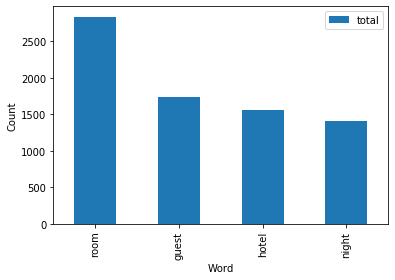

In [37]:
#plotting bar graph of words that appear at least 1000 times
final_top[final_top.total > 1000].plot(kind='bar')
plt.xlabel("Word")
plt.ylabel("Count")

In [38]:
#plotting word cloud to visulise words with the highest frequency
wordplot_string = clean_final_posts['cleaned_post'].str.cat(sep=' ')

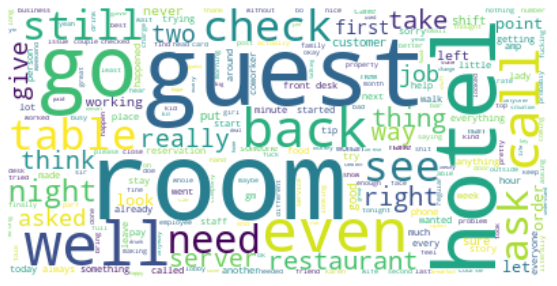

In [39]:
wordcloud = WordCloud(max_font_size=80, max_words=600,
                       background_color="white",
                     contour_width=5, contour_color='firebrick').generate(wordplot_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Visualising data from talesfromthefrontdesk subreddit

In [40]:
cleaned_frontdesk = all_posts.loc[all_posts['frontdesk'] == 1]

In [41]:
cleaned_frontdesk_cvec = cvec.fit_transform(cleaned_frontdesk['cleaned_post'])
cleaned_frontdesk_cvec_df = pd.DataFrame(cleaned_frontdesk_cvec.toarray(), columns=cvec.get_feature_names())

In [42]:
cleaned_frontdesk_count = pd.DataFrame(cleaned_frontdesk_cvec_df.sum(axis = 0))

In [43]:
cleaned_frontdesk_count.columns = ['total']

In [44]:
cleaned_frontdesk_count.sort_values(by = ['total'],ascending = False, inplace = True)

Text(0, 0.5, 'Count')

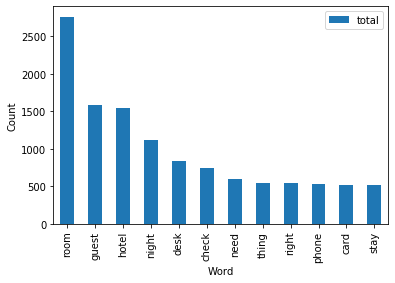

In [45]:
#plotting bar graph of words that appear at least 500 times
cleaned_frontdesk_count[cleaned_frontdesk_count.total > 500].plot(kind='bar')
plt.xlabel("Word")
plt.ylabel("Count")

In [46]:
wordplot_string_f = cleaned_frontdesk['cleaned_post'].str.cat(sep=' ')

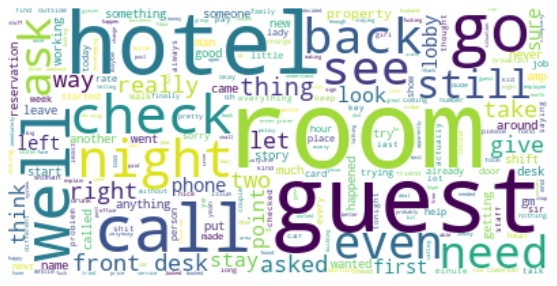

In [47]:
wordcloud = WordCloud(max_font_size=80, max_words=600,
                       background_color="white",
                     contour_width=5, contour_color='firebrick').generate(wordplot_string_f)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Visualising data from talesfromyourserver subreddit

In [48]:
cleaned_service = all_posts.loc[all_posts['frontdesk'] == 0]

In [49]:
cleaned_service_cvec = cvec.fit_transform(cleaned_service['cleaned_post'])
cleaned_service_cvec_df = pd.DataFrame(cleaned_service_cvec.toarray(), columns=cvec.get_feature_names())

In [50]:
cleaned_service_count = pd.DataFrame(cleaned_service_cvec_df.sum(axis = 0))

In [51]:
cleaned_service_count.columns = ['total']

In [52]:
cleaned_service_count.sort_values(by = ['total'],ascending = False, inplace = True)

Text(0, 0.5, 'Count')

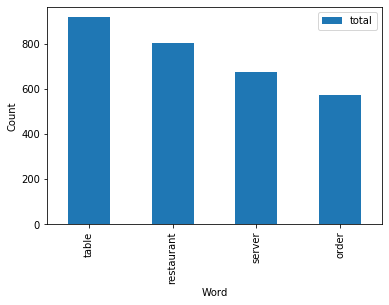

In [53]:
#plotting bar graph of words that appear at least 500 times
cleaned_service_count[cleaned_service_count.total > 500].plot(kind='bar')
plt.xlabel("Word")
plt.ylabel("Count")

In [54]:
wordplot_string_s = cleaned_service['cleaned_post'].str.cat(sep=' ')

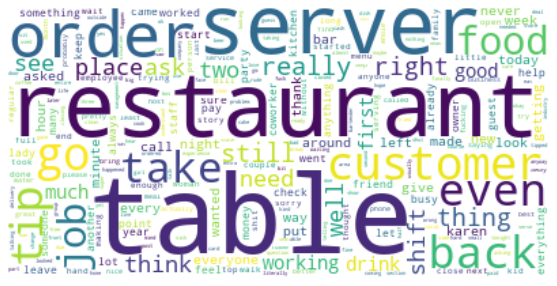

In [55]:
wordcloud = WordCloud(max_font_size=80, max_words=600,
                       background_color="white",
                     contour_width=5, contour_color='firebrick').generate(wordplot_string_s)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Visualising word count across both subreddits

In [56]:
cleaned_service_count.columns = ['service_count']
cleaned_frontdesk_count.columns = ['frontdesk_count']
combined_count = pd.concat([cleaned_service_count, cleaned_frontdesk_count], axis=1, sort=False)
combined_count.head()

,service_count,frontdesk_count
table,917.0,43.0
restaurant,802.0,123.0
server,673.0,29.0
order,575.0,119.0
customer,462.0,120.0


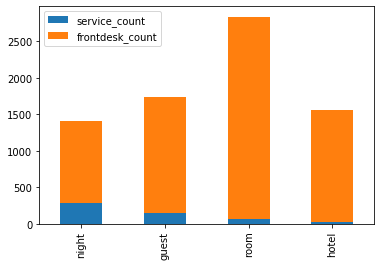

In [57]:
#plotting bar graph of words that appear at least 1000 times
combined_count[combined_count['service_count'] + combined_count['frontdesk_count']> 1000].plot(kind='bar', stacked=True)

Given the words we have observed in both datasets, we are likely to be able to answer the problem statement of classifying feedback/concerns into two categories - service workers in the hospitality industry, and service workers in the F&B industry. This is because there are words which are distinct to each dataset. 

Based on the visualisations, I discovered incomplete words such as 'wa' and 'ha' that do not mean anything, yet occurred frequently. Common words such as 'one', 'say', 'tell' and 'like' etc., which do not help us to differentiate posts between the two subreddits, were also found. I adjusted my 'text processor' function in the *previous* section by creating my own customised list of stop words to remove such words. 

For reference, the customised list of stop words is as follows: 'wa', 'ha', 'like', 'one', 'time', 'people', 'work', 'manager', 'know', 'day', 'say', 'come', 'said', 'want', 'make', 'got', 'told', 'going', 'tell', 'guy'.

### Modelling

Having cleaned the data, we will proceed to use two different classication models for our predictions, Naive Bayes and Logistic Regression. 

For each model, we use CountVectorizer and TfidfVectorizer respectively to treat the data before feeding it into the model. This will convert the words into numbers, which can then be processed by our models. 

Success will be evaluated based on:
- The area under the Receiver Operating Characteristic (ROC) curve, which ranges from 0 to 1.The higher the ROC area under curve (AUC), the more separated our positive and negative populations, and the better our model in classifying the feedback

- The accuracy score, which ranges from 0 to 1. The higher the accuracy score, the more closely our predicted target variables match our true target variables.

#### Baseline scores and what they mean

In [58]:
#split data into X and y
X = all_posts['cleaned_post']
y = all_posts['frontdesk']

In [59]:
y.value_counts(normalize=True)

0    0.529772
1    0.470228
Name: frontdesk, dtype: float64

The baseline accuracy score is **0.52**. If we were to run the data through a dummy classifier, it would return a success rate of 0.525, based on the current split of our classes. It is the success rate one should expect to achieve even if simply guessing. We want our accuracy score to be above this. 

The baseline ROC AUC score is **0.5**. Our model will be predicting whether a piece of feedback/concern belongs to the hospitality industry or F&B industry. It predicts probabilities for each piece of feedback; using these probabilities, we can plot two distributions, one for belonging to the hospitality industry and one for belonging to the F&B industry. When the ROC AUC is 0.5, this means that the predictions are completely overlapping each other i.e. the model is performing poorly and predictions are almost random. We want our ROC AUC score to be above this. 

#### Preparing data for modelling

In [60]:
# split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

#### Model 1: Naive Bayes with CountVectorizer

In [61]:
#setting different values of the parameters for the model to test
ngram_range = [(1,1), (1,2)]
max_features = [30, 40, 50]
min_df = [2, 3]
max_df = [.3, .5, .8]

In [62]:
#instantiating pipeline containing our vectorizer and model
cvec_nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [63]:
cvec_pipe_params = {
    'cvec__ngram_range': ngram_range,
    'cvec__max_features': max_features,
    'cvec__min_df': min_df,
    'cvec__max_df': max_df
}

In [64]:
#performing gridsearch
cvec_nb_gs=GridSearchCV(cvec_nb_pipe, param_grid=cvec_pipe_params, n_jobs=-1, cv=5)


In [65]:
#fitting gridsearch to our train datasets
cvec_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [66]:
#checking best score found in the gridsearch
cvec_nb_gs.best_score_

0.9524870081662955

In [67]:
#checking best parameters that gave the best score
cvec_nb_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 30,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [68]:
#checking the accuracy of the model when used on training data
cvec_nb_gs.score(X_train, y_train)

0.955456570155902

In [69]:
#checking the accuracy of the model when used on testing data
cvec_nb_gs.score(X_test, y_test)

0.9422222222222222

In [70]:
#calculating ROC AUC score when using training data
pred_proba = [i[1] for i in cvec_nb_gs.predict_proba(X_train)]
roc_auc_score(y_train, pred_proba)

0.9835672025524269

In [71]:
#calculating ROC AUC score when using testing data
pred_proba = [i[1] for i in cvec_nb_gs.predict_proba(X_test)]
roc_auc_score(y_test, pred_proba)

0.9843229744728079

#### Model 2: Naive Bayes with TfidfVectorizer

In [72]:
#instantiating pipeline containing our vectorizer and model
tvec_nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [73]:
tvec_pipe_params = {
    'tvec__ngram_range': ngram_range,
    'tvec__max_features': max_features,
    'tvec__min_df': min_df,
    'tvec__max_df': max_df
}

In [74]:
#performing gridsearch
tvec_nb_gs=GridSearchCV(tvec_nb_pipe, param_grid=tvec_pipe_params, n_jobs=-1, cv=5)


In [75]:
#fitting gridsearch to our train datasets
tvec_nb_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [76]:
#checking best score found in the gridsearch
tvec_nb_gs.best_score_

0.9465478841870824

In [77]:
#checking best parameters that gave the best score
tvec_nb_gs.best_params_

{'tvec__max_df': 0.5,
 'tvec__max_features': 30,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [78]:
#checking the accuracy of the model when used on training data
tvec_nb_gs.score(X_train, y_train)

0.9487750556792873

In [79]:
#checking the accuracy of the model when used on testing data
tvec_nb_gs.score(X_test, y_test)

0.94

In [80]:
#calculating ROC AUC score when using training data
pred_proba = [i[1] for i in tvec_nb_gs.predict_proba(X_train)]
roc_auc_score(y_train, pred_proba)

0.985262035303853

In [81]:
#calculating ROC AUC score when using testing data
pred_proba = [i[1] for i in tvec_nb_gs.predict_proba(X_test)]
roc_auc_score(y_test, pred_proba)

0.9860076105914063

#### Model 3: Logistic Regression with CountVectorizer

In [82]:
#instantiating pipeline containing our vectorizer and model
cvec_lr_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

In [83]:
cvec_pipe_params = {
    'cvec__ngram_range': ngram_range,
    'cvec__max_features': max_features,
    'cvec__min_df': min_df,
    'cvec__max_df': max_df
}

In [84]:
#performing gridsearch
cvec_lr_gs=GridSearchCV(cvec_lr_pipe, param_grid=cvec_pipe_params, n_jobs=-1, cv=5)


In [85]:
#fitting gridsearch to our train datasets
cvec_lr_gs.fit(X_train, y_train)

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [86]:
#checking best score found in the gridsearch
cvec_lr_gs.best_score_

0.9517446176688938

In [87]:
#checking best parameters that gave the best score
cvec_lr_gs.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 50,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

In [88]:
#checking the accuracy of the model when used on training data
cvec_lr_gs.score(X_train, y_train)

0.9606533036377134

In [89]:
#checking the accuracy of the model when used on testing data
cvec_lr_gs.score(X_test, y_test)

0.9577777777777777

In [90]:
#calculating ROC AUC score when using training data
pred_proba = [i[1] for i in cvec_lr_gs.predict_proba(X_train)]
roc_auc_score(y_train, pred_proba)

0.9935945942357985

In [91]:
#calculating ROC AUC score when using testing data
pred_proba = [i[1] for i in cvec_lr_gs.predict_proba(X_test)]
roc_auc_score(y_test, pred_proba)

0.9867805612811162

#### Model 4: Logistic Regression with TfidfVectorizer

In [92]:
#instantiating pipeline containing our vectorizer and model
tvec_lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

In [93]:
tvec_pipe_params = {
    'tvec__ngram_range': ngram_range,
    'tvec__max_features': max_features,
    'tvec__min_df': min_df,
    'tvec__max_df': max_df
}

In [94]:
#performing gridsearch
tvec_lr_gs=GridSearchCV(tvec_lr_pipe, param_grid=tvec_pipe_params, n_jobs=-1, cv=5)


In [95]:
#fitting gridsearch to our train datasets
tvec_lr_gs.fit(X_train, y_train)

C:\Users\elton\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [96]:
#checking best score found in the gridsearch
tvec_lr_gs.best_score_

0.9524870081662955

In [97]:
#checking best parameters that gave the best score
tvec_lr_gs.best_params_

{'tvec__max_df': 0.5,
 'tvec__max_features': 50,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

In [98]:
#checking the accuracy of the model when used on training data
tvec_lr_gs.score(X_train, y_train)

0.9532293986636972

In [99]:
#checking the accuracy of the model when used on testing data
tvec_lr_gs.score(X_test, y_test)

0.9488888888888889

In [100]:
#calculating ROC AUC score when using training data
pred_proba = [i[1] for i in tvec_lr_gs.predict_proba(X_train)]
roc_auc_score(y_train, pred_proba)

0.990193865855979

In [101]:
#calculating ROC AUC score when using testing data
pred_proba = [i[1] for i in tvec_lr_gs.predict_proba(X_test)]
roc_auc_score(y_test, pred_proba)

0.9886633898842555

#### Final model evaluation and conceptual understanding

A logistic regression model with tfidfvectorizer gave the highest accuracy of 0.96 (rounded to 2 decimal places), and the highest ROC AUC score of 0.99 (rounded to 2 decimal places) when applied to our testing data. 
- An accuracy score of 0.96 means that 96% of data was accurately classified. This score beats the baseline score of 0.525. 
- A ROC AUC score of 0.99 means that populations are very well-separated, and the model is performing well in its predictions. This score beats the baseline score of 0.5. 

Logistic Regression is a linear model for classification. It allows us to estimate coefficients that tell us the impact of a one-unit change in words on whether the post belongs to the specific subreddit. 

tfidfvectorizer vectorises words by taking into account the frequency of a word in a given document and the frequency between documents. The importance of words increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Therefore, a word which appeared many times in just a few documents would be weighted more heavily and be given more importance. 

In our case, the most frequently-occuring words in both data sets were well-mixed with some words that were common to both, and some that were distinct. We had taken the effort to remove those words which were frequent and common to both datasets, since they would not be helpful for our model. Therefore, the tfidfvectorizer would have been able to weight the remaining words accordingly. 

All the models did a relatively good job of classifying, with comparable accuracy scores and ROC AUC scores - this might mean that the majority of the words in the posts from the two sub-industries are actually more distinct than we had thought. (Naive Bayes is an algorithm based on applying Bayes’ theorem with the assumption of conditional independence between every pair of features.)

Notwithstanding, the logistic regression model with tfidfvectorizer is the model which predicts the best since it gave us the highest accuracy and ROC AUC scores, and it will serve us well in classifying future datasets. 


#### Visualising the ROC curve for our chosen model

In [102]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
459,0,0.002754
502,0,0.240611
1081,1,0.968272
882,0,0.053714
990,1,0.995920
...,...,...
686,0,0.044210
952,1,0.322959
1452,1,0.987008
1108,1,0.430036


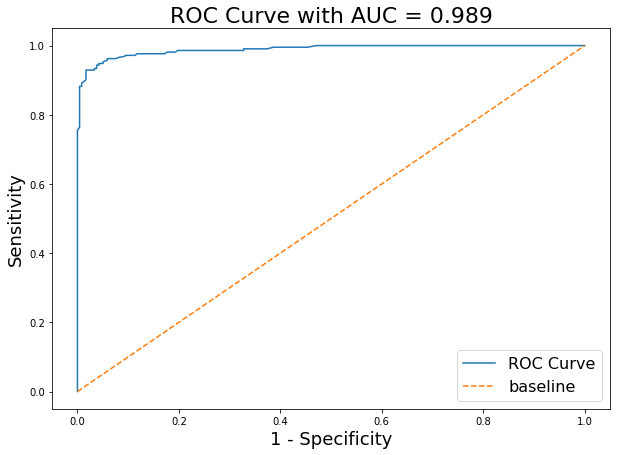

In [103]:
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
        true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
        false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
        return true_positive / (true_positive + false_negative)


# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
        true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
        false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
        return 1 - (true_negative / (true_negative + false_positive))

# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
        tpr_values, # True Positive Rate on Y-axis
        label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        label='baseline',
        linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16); 


#### Understanding the coefficients for our chosen model

In [109]:
tvec_lr_gs.best_estimator_.named_steps['tvec']

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=50,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [104]:
var = np.array(tvec_lr_gs.best_estimator_.named_steps['tvec'].get_feature_names())
coef = tvec_lr_gs.best_estimator_.named_steps['lr'].coef_

tvec_lr_coefs = pd.DataFrame({'variable':var,
                            'coef':np.exp(coef[0])})

tvec_lr_coefs.sort_values('coef', inplace=True, ascending=False)

#looking at the top five coefficients 
tvec_lr_coefs.head(5)

,variable,coef
13,hotel,224.934350
7,desk,103.927704
34,room,99.642226
12,guest,35.931439
31,reservation,9.193134


In [105]:
#looking at the bottom five coefficients
tvec_lr_coefs.tail(5)

,variable,coef
26,order,0.225781
6,customer,0.220473
35,server,0.051633
32,restaurant,0.047635
41,table,0.030525


Based on the coefficients of our chosen model, the top words which *increased* the odds of whether a post/feedback belonged to the hospitality industry or not were:
- desk
- hotel
- room
- guest
- check

The top words which *decreased* the odds that a post/feedback belonged to the hospitality industry were: 
- order
- tip
- restaurant
- server
- table

To further intrepret this, in the case of the word 'desk', if it is present in a post/feedback, this means that the odds of that post/feedback belonging to the hospitality industry increases by 136 times. Based on these coefficients, we can infer which words had the greatest or least impact on a post/feedback being classified as being from the hospitality industry. 

### Conclusion and Recommendations

In conclusion, we ensured that there were large enough data samples (870 and 960) of balanced dataclasses. We also preprocessed the words and performed EDA to understand the frequency and type of words in each dataset. This led to some additional stop words being removed which would help our model. 

We considered logistic regression model and naive bayes model for our classification problem, running our data through CountVectorizer and Tfidfvectorizer in turn. A logistic regression model with tfidfvectorizer gave the highest accuracy of 0.96 (rounded to 2 decimal places), and the highest ROC AUC score of 0.99 (rounded to 2 decimal places) when applied to our testing data. The high scores were consistent across the training and testing data, which means that we have a model that generalises well and can be used to classfy future unseen datasets well. 

With this model, we can now classify new feedback that come from service workers in the hospitality and from the F&B industry with high accuracy. Thereafter, we can further analyse the feedback for each service sub-industry to generate a detailed report for MOM on the current state and concerns of workers in the sub-industries, so that they may use such insights to create and refine policies.  

#### Proposed Next Steps

We can further apply the steps we have taken in this project to develop models that can help to differentiate larger collections of feedback into even more binary sub-industries, and this will help to extend the scope of MOM's study and allow them to understand the feedback and concerns of more sub-industries better. This would greatly benefit their study. 

In terms of the modeling, we could consider using other classification models such as K-nearest neighbours, or we could play around with more parameters in Gridsearch to achieve even better results or greater computing efficiency (which would be important if we are processing a lot of feedback data).

Given that MOM is interested in the service industry in Singapore, we could consider using posts from local forums such as HardwareZone to develop the model, so that the model will be trained on words which Singaporeans might be more likely to use. 